In [1]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
import pandas as pd
import numpy as np
import gensim
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
import itertools
import scipy.sparse
import seaborn as sbn
import time
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.tfidfmodel import TfidfModel
from scipy import spatial

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA

In [5]:
# df1 = pd.read_csv('cleaned_train_bodies_rev.csv')
# df2 = pd.read_csv('cleaned_train_stances_rev.csv')
df1 = pd.read_csv('lemma_train_bodies.csv')
df2 = pd.read_csv('lemma_train_stances.csv')
dfinal = df2.merge(df1, on="Body ID", how='left')

model = Word2Vec.load('lemma_model.model')
word_vectors = model.wv


In [7]:
dfinal.head()

,Headline_cleaned,Body ID,Stance,articleBody_cleaned
0,police find mass grave body near mexico town s...,712,unrelated,danny boyle direct untitled film seth rogen ey...
1,hundred palestinians flee flood gaza israel op...,158,agree,hundred palestinians evacuate home sunday morn...
2,christian bale pass role steve jobs actor repo...,137,unrelated,year old moscow resident hospitalize wound int...
3,hbo apple talk month apple tv streaming servic...,1034,unrelated,reuters canadian soldier shoot canadian war me...
4,spider burrow tourist stomach chest,1923,disagree,fear arachnophobe story bunbury spiderman pert...


In [8]:
corpus = list(df1['articleBody_cleaned']) + list(dfinal['Headline_cleaned'])
voc = list(word_vectors.key_to_index.keys())

In [9]:
vectorizer = TfidfVectorizer(vocabulary=voc)

X = vectorizer.fit_transform(corpus)

# Average Word2Vec (AvgW2Vec)



In [10]:
avg_doc_w2v = {}
max_i = 0
for  id, (i, doc) in zip(df1['Body ID'], enumerate(df1['articleBody_cleaned'])):
  doc_vector = np.zeros(300)
  sum = 0
  count_words = 0
  for word in (doc).split():
    if i > max_i: max_i = i
    if word in word_vectors.key_to_index.keys():
      vec = word_vectors[word]
      doc_vector += vec
      count_words += 1
  if count_words != 0:
    doc_vector = doc_vector / count_words
  avg_doc_w2v[id] = doc_vector

In [11]:
avg_headl_w2v = {}
for id, headline in enumerate(dfinal['Headline_cleaned']):
  doc_vector = np.zeros(300)
  sum = 0
  count_words = 0
  for word in headline.split():
    if word in word_vectors.key_to_index.keys():
        vec = word_vectors[word]
        sum += vec
        count_words += 1
  if count_words != 0:
    avg_headl_w2v[id] = sum / count_words

In [12]:
dataset_avg = pd.DataFrame()
dataset_avg['Body ID'] = pd.Series(avg_doc_w2v.keys())
art_avg_dataset = pd.DataFrame(avg_doc_w2v.values())
head_avg_dataset = pd.DataFrame(avg_headl_w2v.values())

head_avg_dataset.rename(columns={i:i+300 for i in range(300)}, inplace=True)
dat_avg = pd.concat([dataset_avg, art_avg_dataset], axis=1)
dfinal_avg = pd.merge(dfinal, dat_avg, on="Body ID", how='left')
dfinal_avg = pd.concat([dfinal_avg, head_avg_dataset], axis=1)
dfinal_avg.drop('Headline_cleaned', inplace=True, axis=1)
dfinal_avg.drop('Body ID', inplace=True, axis=1)
dfinal_avg.drop('articleBody_cleaned', inplace=True, axis=1)


In [13]:
enc = LabelEncoder()
dfinal_avg['Stance'] = enc.fit_transform(dfinal_avg['Stance'])

dfinal_avg.head()

,Stance,0,1,2,3,4,5,6,7,8,...,590,591,592,593,594,595,596,597,598,599
0,3,0.233251,0.003848,-0.144631,0.054561,-0.436142,-0.135662,0.182725,-0.117671,0.065578,...,-0.022538,0.310036,0.364328,0.332978,-0.011531,-0.044545,0.124954,0.069305,0.043249,0.025858
1,0,-0.136003,0.198923,0.240495,0.299356,0.062280,-0.324793,-0.033531,0.106847,-0.100596,...,-0.091982,0.189232,-0.180853,-0.144466,0.283486,-0.534003,0.078676,0.023560,0.088828,0.346396
2,3,-0.219729,0.093512,0.057356,0.156283,-0.034740,-0.241713,-0.059886,-0.037938,-0.031954,...,0.011727,-0.186778,0.063805,-0.002368,0.240981,0.234610,-0.535876,-0.553030,-0.070884,0.302070
3,3,-0.288073,0.328400,0.026227,0.242756,-0.163041,-0.399518,0.043186,0.058226,-0.180083,...,-0.205768,0.600725,-0.035737,-0.232806,0.424177,-0.014720,-0.297229,0.180855,0.241998,-0.030574
4,1,0.016964,0.158677,0.149708,0.128668,-0.067419,-0.354840,0.139566,-0.025145,0.100298,...,-0.499987,-0.196560,0.290981,0.023244,0.171163,0.403861,0.030590,0.245909,0.021718,0.237405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,3,-0.028036,0.132891,0.115802,0.232730,-0.167176,-0.280824,0.177998,0.153286,0.083710,...,0.026078,-0.310037,-0.014103,-0.142691,0.098249,-0.108891,-0.061797,0.243964,0.065916,0.122464
49968,3,0.107586,0.185520,0.003799,0.116002,0.060502,-0.276953,-0.075419,-0.056120,0.184077,...,0.117073,0.490058,-0.042678,0.010798,-0.082957,0.048204,-0.370927,-0.317732,0.302176,0.176489
49969,0,-0.234173,0.157196,0.215941,0.215866,0.004969,-0.426807,0.554952,-0.187095,-0.029814,...,0.067294,0.317409,0.365581,0.318729,0.005489,0.062257,0.172799,-0.110738,0.139617,0.028386
49970,2,-0.290686,0.261973,0.254980,0.105788,-0.144965,-0.355796,0.035069,0.200945,-0.021387,...,-0.103746,0.268281,0.158702,0.004476,0.179312,-0.046666,-0.108947,-0.022682,0.081807,-0.119495


# TF-IDF-Average_W2Vec (TFIDF-AvgW2Vec)

In [14]:
def make_tfidf_scores(doc, X, vectorizer):
  feature_index = X[doc,:].nonzero()[1]
  feature_names = vectorizer.get_feature_names_out()
  tfidf_scores = zip(feature_index, [X[doc, x] for x in feature_index])
  tfidf_dict = {}
  for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    tfidf_dict[w] = s
  
  return tfidf_dict

In [23]:
# docs
tfidf_doc_vectors_rev = {}
max_i = 0
for  id, (i, doc) in zip(df1['Body ID'], enumerate(df1['articleBody_cleaned'])):
  doc_vector = np.zeros(300)
  weight_sum = 0
  tfidf_dict = make_tfidf_scores(i, X, vectorizer)
  for word in (doc).split():
      if i > max_i: max_i = i
      if word in tfidf_dict.keys() and word in word_vectors.key_to_index.keys():
        vec = word_vectors[word]
        tf_idf = tfidf_dict[word] * (doc.count(word)/ len(doc))
        doc_vector += vec * tf_idf
        weight_sum += tf_idf

      
  if weight_sum != 0:    
    doc_vector = doc_vector / weight_sum
    
  tfidf_doc_vectors_rev[id] = doc_vector

In [24]:
# headlines

tfidf_headl_vectors_rev = {}
for id, headline in enumerate(dfinal['Headline_cleaned']):
  doc_vector = np.zeros(300)
  weight_sum = 0
  tfidf_dict = make_tfidf_scores(id+max_i+1, X, vectorizer)
  for word in headline.split():
    if word in tfidf_dict.keys() and word in word_vectors.key_to_index.keys():
        vec = word_vectors[word]
        tf_idf = tfidf_dict[word] * (headline.count(word)/ len(headline))
        doc_vector += vec * tf_idf
        weight_sum += tf_idf
  if weight_sum != 0:
    doc_vector = doc_vector / weight_sum
  tfidf_headl_vectors_rev[id] = doc_vector

In [25]:
dataset = pd.DataFrame()
dataset['Body ID'] = pd.Series(tfidf_doc_vectors_rev.keys())
art_dataset = pd.DataFrame(tfidf_doc_vectors_rev.values())
head_dataset = pd.DataFrame(tfidf_headl_vectors_rev.values())

head_dataset.rename(columns={i:i+300 for i in range(300)}, inplace=True)
dat = pd.concat([dataset, art_dataset], axis=1)

final_dataset = pd.merge(dfinal, dat, on="Body ID", how='left')
final_dataset = pd.concat([final_dataset, head_dataset], axis=1)
final_dataset.head()

,Headline_cleaned,Body ID,Stance,articleBody_cleaned,0,1,2,3,4,5,...,590,591,592,593,594,595,596,597,598,599
0,police find mass grave body near mexico town s...,712,unrelated,danny boyle direct untitled film seth rogen ey...,0.282314,-0.100485,-0.269257,-0.003902,-0.418086,-0.060294,...,0.109549,0.407010,0.243780,0.327656,-0.179278,0.007440,-0.001546,0.164878,0.013704,0.132657
1,hundred palestinians flee flood gaza israel op...,158,agree,hundred palestinians evacuate home sunday morn...,-0.089057,0.716329,0.245567,0.614748,0.324536,-0.295148,...,-0.088385,0.207194,-0.178422,-0.136783,0.285687,-0.544433,0.101479,0.033272,0.086645,0.344493
2,christian bale pass role steve jobs actor repo...,137,unrelated,year old moscow resident hospitalize wound int...,-0.246510,0.109737,0.115684,0.210950,0.101279,-0.176397,...,0.011552,-0.201086,0.067882,-0.040401,0.237621,0.228367,-0.533938,-0.568859,-0.124451,0.324780
3,hbo apple talk month apple tv streaming servic...,1034,unrelated,reuters canadian soldier shoot canadian war me...,-0.397735,0.367965,0.054882,0.232550,-0.107398,-0.409974,...,-0.250465,0.697736,-0.073829,-0.339228,0.596949,0.083545,-0.375157,0.328264,0.331444,-0.018558
4,spider burrow tourist stomach chest,1923,disagree,fear arachnophobe story bunbury spiderman pert...,0.001767,0.216638,0.153772,0.203075,0.055249,-0.551733,...,-0.502349,-0.225442,0.273993,-0.008074,0.195075,0.387087,0.036175,0.237688,0.017867,0.249785


In [26]:
final_dataset.drop('Headline_cleaned', inplace=True, axis=1)
final_dataset.drop('Body ID', inplace=True, axis=1)
final_dataset.drop('articleBody_cleaned', inplace=True, axis=1)
final_dataset.head()

,Stance,0,1,2,3,4,5,6,7,8,...,590,591,592,593,594,595,596,597,598,599
0,unrelated,0.282314,-0.100485,-0.269257,-0.003902,-0.418086,-0.060294,0.250497,-0.220670,-0.060788,...,0.109549,0.407010,0.243780,0.327656,-0.179278,0.007440,-0.001546,0.164878,0.013704,0.132657
1,agree,-0.089057,0.716329,0.245567,0.614748,0.324536,-0.295148,-0.071076,0.532059,-0.304056,...,-0.088385,0.207194,-0.178422,-0.136783,0.285687,-0.544433,0.101479,0.033272,0.086645,0.344493
2,unrelated,-0.246510,0.109737,0.115684,0.210950,0.101279,-0.176397,-0.165452,-0.037159,-0.000405,...,0.011552,-0.201086,0.067882,-0.040401,0.237621,0.228367,-0.533938,-0.568859,-0.124451,0.324780
3,unrelated,-0.397735,0.367965,0.054882,0.232550,-0.107398,-0.409974,0.012585,0.021868,-0.200963,...,-0.250465,0.697736,-0.073829,-0.339228,0.596949,0.083545,-0.375157,0.328264,0.331444,-0.018558
4,disagree,0.001767,0.216638,0.153772,0.203075,0.055249,-0.551733,0.357010,-0.086546,0.177242,...,-0.502349,-0.225442,0.273993,-0.008074,0.195075,0.387087,0.036175,0.237688,0.017867,0.249785


In [27]:
enc = LabelEncoder()
final_dataset['Stance'] = enc.fit_transform(final_dataset['Stance'])
final_dataset

,Stance,0,1,2,3,4,5,6,7,8,...,590,591,592,593,594,595,596,597,598,599
0,3,0.282314,-0.100485,-0.269257,-0.003902,-0.418086,-0.060294,0.250497,-0.220670,-0.060788,...,0.109549,0.407010,0.243780,0.327656,-0.179278,0.007440,-0.001546,0.164878,0.013704,0.132657
1,0,-0.089057,0.716329,0.245567,0.614748,0.324536,-0.295148,-0.071076,0.532059,-0.304056,...,-0.088385,0.207194,-0.178422,-0.136783,0.285687,-0.544433,0.101479,0.033272,0.086645,0.344493
2,3,-0.246510,0.109737,0.115684,0.210950,0.101279,-0.176397,-0.165452,-0.037159,-0.000405,...,0.011552,-0.201086,0.067882,-0.040401,0.237621,0.228367,-0.533938,-0.568859,-0.124451,0.324780
3,3,-0.397735,0.367965,0.054882,0.232550,-0.107398,-0.409974,0.012585,0.021868,-0.200963,...,-0.250465,0.697736,-0.073829,-0.339228,0.596949,0.083545,-0.375157,0.328264,0.331444,-0.018558
4,1,0.001767,0.216638,0.153772,0.203075,0.055249,-0.551733,0.357010,-0.086546,0.177242,...,-0.502349,-0.225442,0.273993,-0.008074,0.195075,0.387087,0.036175,0.237688,0.017867,0.249785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,3,-0.064214,0.312577,0.140572,0.333582,-0.251622,-0.374893,0.291391,0.256072,-0.033361,...,0.040356,-0.350061,-0.010037,-0.164557,0.053028,-0.138926,-0.084410,0.235873,0.072633,0.103394
49968,3,0.157753,0.265695,-0.038472,0.122487,0.187142,-0.181835,0.096380,-0.290800,0.267768,...,0.134261,0.483265,-0.038276,0.001544,-0.097017,0.071814,-0.409545,-0.310409,0.296405,0.208284
49969,0,-0.240093,0.173861,0.220040,0.231504,0.026952,-0.430924,0.557617,-0.184797,-0.019833,...,0.053573,0.328015,0.385678,0.337200,0.006071,0.021441,0.186498,-0.098336,0.143859,0.003904
49970,2,-0.388848,0.338854,0.300227,0.051144,-0.112746,-0.392303,0.026005,0.289471,-0.100670,...,-0.061032,0.183837,0.237742,0.040215,0.100638,-0.102144,-0.097255,0.077102,0.094647,-0.140051


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
     final_dataset.loc[:, final_dataset.columns != 'Stance'], final_dataset['Stance'], test_size=0.20, random_state=42)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
     dfinal_avg.loc[:, dfinal_avg.columns != 'Stance'], dfinal_avg['Stance'], test_size=0.20, random_state=42)

In [29]:
X_train.shape

(39977, 600)

In [17]:
selector = VarianceThreshold()
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
pca = PCA()
ros = RandomOverSampler()

In [18]:
mlp_clf = MLPClassifier()

steps = [('scaler', min_max_scaler),
         ('ros', ros),
         ('pca', pca),
         ('mlp', mlp_clf)]

pipe = Pipeline(steps=steps, memory='tmp')

n_components = [600]
alpha = [0.0001]
activation = ['relu']
hidden_layer_sizes = [(300, 200, 200)]
# 'pca__n_components':n_components,
params = {'pca__n_components':n_components,
          'mlp__hidden_layer_sizes': hidden_layer_sizes,
          'mlp__activation': activation,
          'mlp__alpha': alpha}

estimator = GridSearchCV(pipe, param_grid=params, cv=10, scoring='f1_macro', n_jobs=-1)
start_time = time.time()

estimator.fit(X_train, y_train)
mlp_preds = estimator.predict(X_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:217: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],


In [19]:
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, mlp_preds))
print(estimator.best_estimator_)
print(estimator.best_params_)

Συνολικός χρόνος fit και predict: 4292.765870809555 seconds
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       703
           1       0.87      0.77      0.82       180
           2       0.96      0.97      0.97      1779
           3       1.00      1.00      1.00      7333

    accuracy                           0.98      9995
   macro avg       0.94      0.91      0.92      9995
weighted avg       0.98      0.98      0.98      9995

Pipeline(memory='tmp',
         steps=[('scaler', MinMaxScaler()), ('ros', RandomOverSampler()),
                ('pca', PCA(n_components=600)),
                ('mlp', MLPClassifier(hidden_layer_sizes=(300, 200, 200)))])
{'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (300, 200, 200), 'pca__n_components': 600}


In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [21]:
cf_matrix = confusion_matrix(y_test, mlp_preds)
print(cf_matrix)

[[ 639   16   45    3]
 [  27  139   11    3]
 [  32    4 1727   16]
 [   3    0   13 7317]]


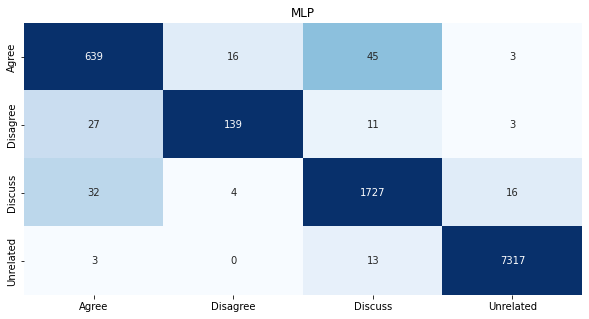

In [22]:
fig = plt.figure(figsize=(10, 5))
plt.title("MLP")
labels = ['Agree', 'Disagree', 'Discuss', 'Unrelated']
sns.heatmap(cf_matrix, annot=True, cmap='Blues',vmin=5,vmax=100,fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.show()